# §1: Setup and data

In [5]:
# Import libraries
from google.cloud import bigquery
from google.cloud import bigquery_storage

import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os

In [6]:
# Setup Google Cloud credentials
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/path/to/your/service-account-key.json"

# Store the service key in the corresponding location in colab files
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/kamronaggor/Desktop/School/URI/DSP 461/Machine-Learning-Final/credentials/machine-learning-final-477822-031ba3aac2f9.json"

## Loading data from Bigquery
Here we use the bigquery library to send requests to bq api where our data is stored

In [7]:
load_dotenv()

from google.cloud import bigquery
client = bigquery.Client(project="machine-learning-final-477822")

## Creating our Dataframes

In [8]:
# Query the full ACS census tract table:
query = """
SELECT *
FROM `bigquery-public-data.census_bureau_acs.censustract_2020_5yr`
"""
# Run query
query_job = client.query(query)

acs_df = query_job.result().to_dataframe(create_bqstorage_client=False)

print("Loaded ACS dataframe with shape:", acs_df.shape)
acs_df.head()

KeyboardInterrupt: 

In [ ]:
# From here we filter into DP05 and DP03 as needed for analysis

# DP03: Economic features
dp03_cols = [
    "median_income",
    "income_per_capita",
    "poverty",
    "pop_in_labor_force",
    "employed_pop",
    "unemployed_pop",
    "not_in_labor_force",
    "commuters_16_over",
    "aggregate_travel_time_to_work",
    "commute_less_10_mins",
    "commute_5_9_mins",
    "commute_10_14_mins",
    "commute_15_19_mins",
    "commute_20_24_mins",
    "commute_25_29_mins",
    "commute_30_34_mins",
    "commute_35_39_mins",
    "commute_40_44_mins",
    "commute_45_59_mins",
    "commute_60_more_mins",
    "worked_at_home",
    "walked_to_work",
    "no_car",
    "one_car",
    "two_cars",
    "three_cars",
    "four_more_cars",
    "gini_index",
    ]

# DP05: Demographic features
dp05_cols = [
    "total_pop",
    "male_pop",
    "female_pop",
    "male_under_5",
    "male_5_to_9",
    "male_10_to_14",
    "male_15_to_17",
    "male_18_to_19",
    "male_20",
    "male_21",
    "male_22_to_24",
    "male_25_to_29",
    "male_30_to_34",
    "male_35_to_39",
    "male_40_to_44",
    "male_45_to_49",
    "male_50_to_54",
    "male_55_to_59",
    "male_60_to_61",
    "male_62_to_64",
    "male_65_to_66",
    "male_67_to_69",
    "male_70_to_74",
    "male_75_to_79",
    "male_80_to_84",
    "male_85_and_over",
    "female_under_5",
    "female_5_to_9",
    "female_10_to_14",
    "female_15_to_17",
    "female_18_to_19",
    "female_20",
    "female_21",
    "female_22_to_24",
    "female_25_to_29",
    "female_30_to_34",
    "female_35_to_39",
    "female_40_to_44",
    "female_45_to_49",
    "female_50_to_54",
    "female_55_to_59",
    "female_60_to_61",
    "female_62_to_64",
    "female_65_to_66",
    "female_67_to_69",
    "female_70_to_74",
    "female_75_to_79",
    "female_80_to_84",
    "female_85_and_over",
    "white_pop",
    "black_pop",
    "asian_pop",
    "amerindian_pop",
    "other_race_pop",
    "two_or_more_races_pop",
    "hispanic_pop",
    "white_including_hispanic",
    "black_including_hispanic",
    "asian_including_hispanic",
    ]


# §2: Cleaning

In [ ]:
# Create target variable 'high_rent_burden' 
acs_df['high_rent_burden'] = acs_df['percent_income_spent_on_rent'] >= 30

acs_df['high_rent_burden'].head()

0     True
1    False
2    False
3    False
4    False
Name: high_rent_burden, dtype: bool

In [ ]:
# Handling Sentinel Codes:
sentinel_values = [-666666666, -777777777, -888888888, -999999999]
acs_df.replace(sentinel_values, pd.NA, inplace=True)

In [ ]:
# We need to convert some columns to numeric
# We need to cast geo_id and high_rent_burden:
acs_df["geo_id"] = acs_df["geo_id"].astype(str)
acs_df["high_rent_burden"] = acs_df["high_rent_burden"].astype(int)
acs_df["gini_index"] = pd.to_numeric(acs_df["gini_index"], errors='coerce')
acs_df["income_per_capita"] = pd.to_numeric(acs_df["income_per_capita"], errors='coerce')
acs_df["median_age"] = pd.to_numeric(acs_df["median_age"], errors='coerce')
acs_df["median_income"] = pd.to_numeric(acs_df["median_income"], errors='coerce')
acs_df["median_rent"] = pd.to_numeric(acs_df["median_rent"], errors='coerce')
acs_df["median_year_structure_built"] = pd.to_numeric(acs_df["median_year_structure_built"], errors='coerce')
acs_df["owner_occupied_housing_units_lower_value_quartile"] = pd.to_numeric(acs_df["owner_occupied_housing_units_lower_value_quartile"], errors='coerce')
acs_df["owner_occupied_housing_units_median_value"] = pd.to_numeric(acs_df["owner_occupied_housing_units_median_value"], errors='coerce')
acs_df["owner_occupied_housing_units_upper_value_quartile"] = pd.to_numeric(acs_df["owner_occupied_housing_units_upper_value_quartile"], errors='coerce')
acs_df["percent_income_spent_on_rent"] = pd.to_numeric(acs_df["percent_income_spent_on_rent"], errors='coerce')
acs_df["renter_occupied_housing_units_paying_cash_median_gross_rent"] = pd.to_numeric(acs_df["renter_occupied_housing_units_paying_cash_median_gross_rent"], errors='coerce')

Some of these measures are not really useful as pure counts, such as `unemployment_pop`, `vacant_housing_units`, etc. This is because they will end up dominating the model and also make it difficult to generalize across other areas of the country. Rather, we should insert corresponding rates columns:

In [ ]:
acs_df["unemployment_rate"] = acs_df["unemployed_pop"] / acs_df["civilian_labor_force"]
acs_df["vacancy_rate"] = acs_df["vacant_housing_units"] / acs_df["occupied_housing_units"]
acs_df["renter_share"] = acs_df["housing_units_renter_occupied"] / acs_df["occupied_housing_units"]

In [ ]:
acs_df['percent_bachelors_or_higher'] = (acs_df['bachelors_degree_or_higher_25_64'] / acs_df['pop_25_64']).replace([np.inf, -np.inf], np.nan)
acs_df['children_per_adult'] = (acs_df['children'] / (acs_df['total_pop'] - acs_df['children'])).replace([np.inf, -np.inf], np.nan)
acs_df['non_white_percent'] = ((acs_df['total_pop'] - acs_df['white_pop']) / acs_df['total_pop']).replace([np.inf, -np.inf], np.nan)

# Replace infinite values so the model pipeline can impute them
acs_df.replace([np.inf, -np.inf], np.nan, inplace=True)


# §4: Modeling

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import geopandas as gpd
import folium

# Feature Consolidation
new_features = ['unemployment_rate', 'vacancy_rate', 'renter_share', 'percent_bachelors_or_higher', 'children_per_adult', 'non_white_percent', 'latitude', 'longitude']
feature_cols = dp03_cols + dp05_cols + new_features

# Drop duplicate features if any
feature_cols = list(dict.fromkeys(feature_cols))

model_df = acs_df[['geo_id'] + feature_cols + ['high_rent_burden']].copy()

# Drop rows with no target
model_df.dropna(subset=['high_rent_burden'], inplace=True)

# Separate features and target
X = model_df.drop(columns=['high_rent_burden', 'geo_id'])
y = model_df['high_rent_burden']

# Identify numeric features
numeric_features = X.select_dtypes(include=np.number).columns.tolist()

# Pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)],
    remainder='drop'
    )
# Splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Parameter tuning
gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(random_state=42))])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.1, 0.05],
    'classifier__max_depth': [3, 4]
}

grid_search = GridSearchCV(gb_pipeline, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Eval
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100; total time= 5.0min
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100; total time= 5.0min
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100; total time= 5.0min
[CV] END classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=100; total time= 6.9min
[CV] END classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=100; total time= 6.9min
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200; total time= 9.7min
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200; total time= 9.7min
[CV] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=200; total time= 9.7min
[CV] END classifier__learnin

# §5: Model Interpretation

In [ ]:
!pip install shap

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.4/558.4 kB 6.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 15.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 MB 14.9 MB/s  0:00:02m0:00:0100:01
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [shap]5/6 [shap]]te]


100%|===================| 17016/17079 [01:32<00:00]        

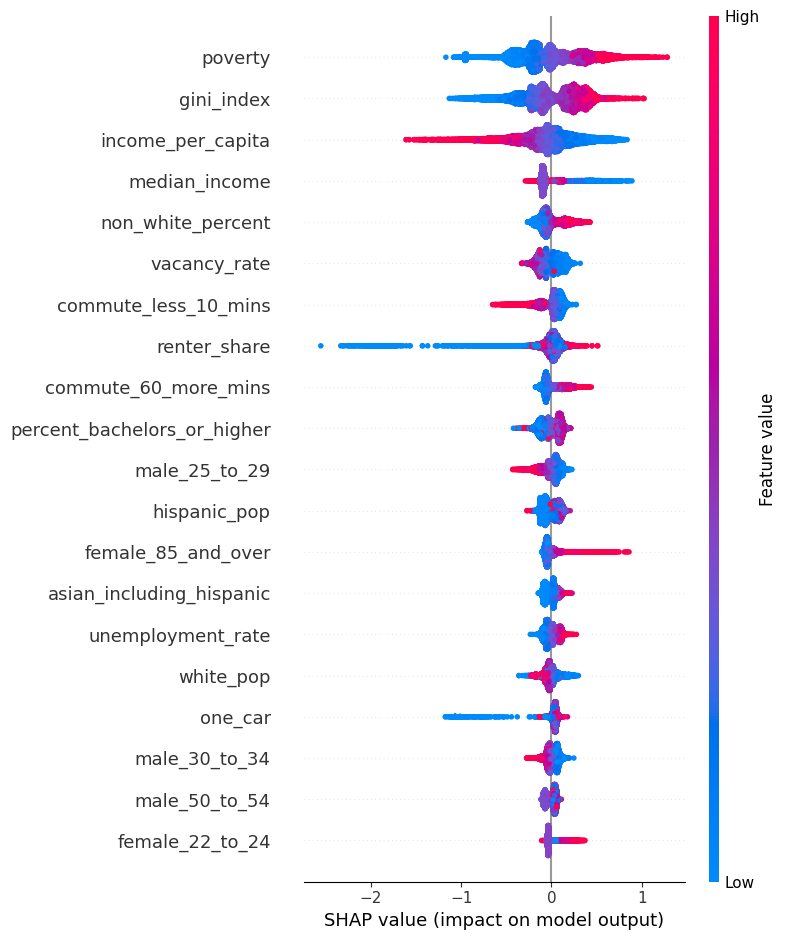

In [ ]:
import shap

X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=numeric_features)

# Create SHAP explainer for the trained classifier
explainer = shap.Explainer(
    best_model.named_steps['classifier'],
    X_train_transformed,
    feature_names=numeric_features,
)

# Disable additivity check to avoid logit/probability mismatches
shap_values = explainer(X_test_transformed, check_additivity=False)

shap.summary_plot(shap_values, X_test_transformed_df, feature_names=numeric_features)


§6: Error Analysis Map

In [ ]:
from pathlib import Path
import geopandas as gpd

# Load shapefile directly from the zip and filter to Rhode Island
shapefile_zip = 'notebooks/data/tl_2018_44_tract.zip'
ri_tracts = gpd.read_file(f"zip://{shapefile_zip}")
ri_tracts = ri_tracts[ri_tracts.STATEFP == '44']
ri_tracts['GEOID'] = ri_tracts['GEOID'].astype(str).str.zfill(11)

# Calculate centroids and extract lat/lon
ri_tracts['latitude'] = ri_tracts.geometry.centroid.y
ri_tracts['longitude'] = ri_tracts.geometry.centroid.x

# Merge geospatial features with acs_df
geospatial_features = ri_tracts[['GEOID', 'latitude', 'longitude']]
acs_df = pd.merge(acs_df, geospatial_features, left_on='geo_id', right_on='GEOID', how='left')
acs_df.drop(columns=['GEOID'], inplace=True, errors='ignore')

# Now, let's re-create the error analysis part, ensuring model_df is defined first
features_all = model_df.drop(columns=['high_rent_burden', 'geo_id'])
all_preds = best_model.predict(features_all)

all_df = model_df[['geo_id', 'high_rent_burden']].copy()
all_df['high_rent_burden_pred'] = all_preds
all_df['prediction_error'] = all_df['high_rent_burden_pred'] - all_df['high_rent_burden']
all_df['geo_id'] = all_df['geo_id'].astype(str).str.zfill(11)

# Merge with prediction errors for all tracts
map_gdf = ri_tracts.merge(all_df, left_on='GEOID', right_on='geo_id', how='left')

# Create map
m = folium.Map(location=[41.7, -71.5], zoom_start=10)

folium.Choropleth(
    geo_data=map_gdf.to_json(),
    name='Prediction Error',
    data=map_gdf,
    columns=['GEOID', 'prediction_error'],
    key_on='feature.properties.GEOID',
    fill_color='RdBu',
    fill_opacity=0.4,
    line_opacity=1,
    legend_name='Prediction Error (1: False Positive, -1: False Negative)',
    bins=[-1, 0, 1]
    ).add_to(m)

folium.LayerControl().add_to(m)
m

# Metrics

In [ ]:
# Calculate metrics
